In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")
episodes = episodes.assign(family=episodes.protocol)


def protocol(row):
    if row.family == "nakamoto":
        return "nakamoto"
    elif row.family == "bk":
        return f"bk-{row.k}"
    elif row.family == "tailstorm":
        return f"tailstorm-{row.k}-{row.reward}"
    else:
        assert false


episodes = episodes.assign(protocol=episodes.apply(protocol, axis=1))
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'batch',
 'learning_rate',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    policies=episodes.query("kind == 'hard-coded'").policy.drop_duplicates().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'policies': ['minor-delay', 'get-ahead', 'honest', 'sapirshtein-2016-sm1'],
 'n_episodes': 100,
 'n_models': 1292}

In [4]:
setting_key = ["protocol", "family", "k", "subblock_selection", "alpha", "gamma"]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,subblock_selection,alpha,gamma
0,bk-8,bk,8,n/a,0.20,0.05
1,bk-8,bk,8,n/a,0.20,0.50
2,bk-8,bk,8,n/a,0.20,0.95
3,bk-8,bk,8,n/a,0.25,0.05
4,bk-8,bk,8,n/a,0.25,0.50
...,...,...,...,...,...,...
67,tailstorm-8-discount,tailstorm,8,heuristic,0.40,0.50
68,tailstorm-8-discount,tailstorm,8,heuristic,0.40,0.95
69,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.05
70,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.50


In [5]:
point_key = setting_key + ["policy"]
hard_coded_episodes = (
    episodes.query('kind == "hard-coded"').sort_values(point_key).reset_index(drop=True)
)
points = (
    hard_coded_episodes.groupby(point_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
    )
    .reset_index()
)
points

,protocol,family,k,subblock_selection,alpha,gamma,policy,n,relrew_mean,relrew_std,rpp_mean,rpp_std
0,bk-8,bk,8,n/a,0.20,0.05,get-ahead,100,0.083552,0.008874,0.083552,0.008874
1,bk-8,bk,8,n/a,0.20,0.05,honest,100,0.198574,0.009212,0.198574,0.009212
2,bk-8,bk,8,n/a,0.20,0.05,minor-delay,100,0.116556,0.017009,0.116556,0.017009
3,bk-8,bk,8,n/a,0.20,0.50,get-ahead,100,0.088842,0.009070,0.088842,0.009070
4,bk-8,bk,8,n/a,0.20,0.50,honest,100,0.199626,0.009520,0.199626,0.009520
...,...,...,...,...,...,...,...,...,...,...,...,...
193,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.50,honest,100,0.450837,0.011349,0.450837,0.011349
194,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.50,minor-delay,100,0.563759,0.027677,0.480844,0.023422
195,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95,get-ahead,100,0.279349,0.050659,0.241265,0.044177
196,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95,honest,100,0.450358,0.011363,0.450358,0.011363


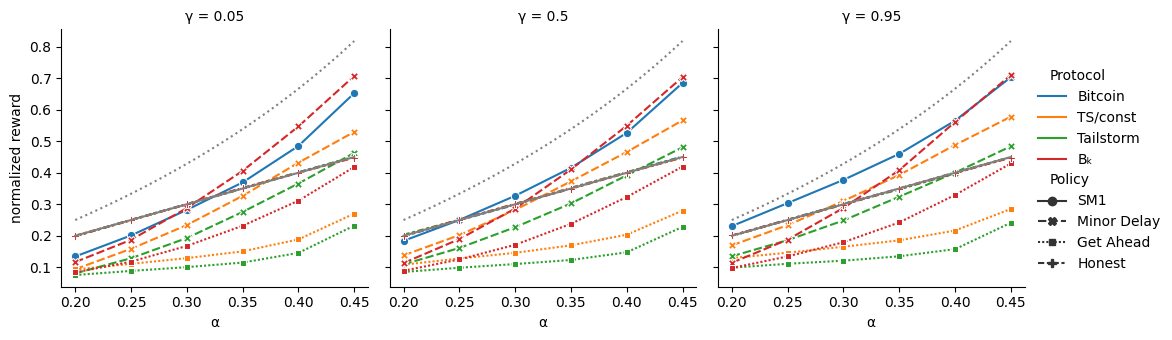

In [6]:
# subset = points.query('family != "bk"')
subset = points


# Some renaming for the paper
def humProtocol(x):
    if x == "nakamoto":
        return "Bitcoin"
    if x == "tailstorm-8-discount":
        return "Tailstorm"
    if x == "tailstorm-8-constant":
        return "TS/const"
    if x == "bk-8":
        return "Bₖ"
    raise ValueError(f"unknown protocol: {x}")


def humPolicy(x):
    if x == "sapirshtein-2016-sm1":
        return "SM1"
        return "SM1 (SSZ '16)"
    if x == "avoid-loss":
        return "Avoid Loss"
    if x == "get-ahead":
        return "Get Ahead"
    if x == "minor-delay":
        return "Minor Delay"
    if x == "honest":
        return "Honest"
    raise ValueError(f"unknown policy: {x}")


subset = subset.assign(
    Protocol=subset.protocol.map(humProtocol), Policy=subset.policy.map(humPolicy)
)
subset.Protocol = pd.Categorical(
    subset.Protocol, categories=["Bitcoin", "TS/const", "Tailstorm", "Bₖ"]
)
subset.Policy = pd.Categorical(
    subset.Policy,
    # categories=["SM1", "Minor Delay", "Get Ahead", "Avoid Loss", "Honest"],
    categories=["SM1", "Minor Delay", "Get Ahead", "Honest"],
)
subset["γ"] = subset.gamma
subset["α"] = subset.alpha

fig = sns.relplot(
    kind="line",
    data=subset,
    y="rpp_mean",
    x="α",
    col="γ",
    hue="Protocol",
    style="Policy",
    markers=True,
    height=3.5,
    aspect=1,
)
fig.set(ylabel="normalized reward")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(points.alpha), max(points.alpha), 20)
    ax.plot(alpha, alpha, linestyle="solid", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")


fig.savefig(
    "reward_per_progress_hard_coded.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

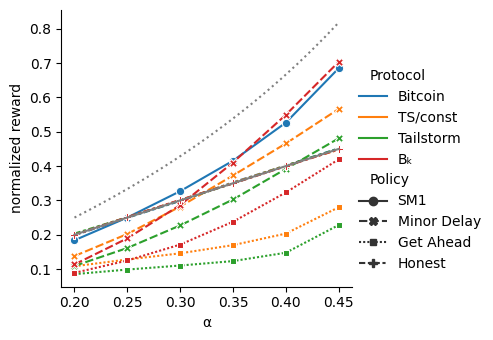

In [7]:
fig = sns.relplot(
    kind="line",
    data=subset.query("gamma == 0.5"),
    y="rpp_mean",
    x="α",
    hue="Protocol",
    style="Policy",
    markers=True,
    height=3.5,
    aspect=1.1,
)
fig.set(ylabel="normalized reward")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(points.alpha), max(points.alpha), 20)
    ax.plot(alpha, alpha, linestyle="solid", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")


fig.savefig(
    "reward_per_progress_hard_coded_gamma50.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)